# Deep Learning Assignment 1

Authors:
1. Jordan Conrad-Burton
2. Moshe Shem Tov

In [ ]:
# pytorch installation
!pip install torch torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
import torchvision
import numpy as np
import math
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## 1. Forward Propagation

In [ ]:
def initialize_parameters(layer_dims):
  parameter_dictionary = {}
  L = len(layer_dims)

  for l in range(1, L):
    initialized_W = np.random.randn(layer_dims[l], layer_dims[l - 1]).astype(np.double) * np.sqrt(2 / layer_dims[l - 1])
    initialized_b = np.zeros((layer_dims[l], 1), dtype=np.double)
    parameter_dictionary[l] = (initialized_W, initialized_b)

  return parameter_dictionary

In [ ]:
def linear_forward(A, W, b):

  A, W, b = A.double(), W.double(), b.double()
  linear_cache = {'A': A, 'W': W, 'b': b}
  Z = torch.matmul(W, A) + b

  return Z, linear_cache

In [ ]:
def softmax(Z):
  activation_cache = {'Z': Z}

  exp_Z = torch.exp(Z)
  A = exp_Z / torch.sum(exp_Z, axis=0, keepdims=True)

  return A, activation_cache

In [ ]:
def relu(Z):
  activation_cache = {'Z': Z}
  zeros = torch.zeros_like(Z)

  A = torch.maximum(zeros, Z)

  return A, activation_cache

In [ ]:
def linear_activation_forward(A_prev, W, B, activation):

  Z, linear_cache = linear_forward(A_prev, W, B)
  Z_cache = {}
  cache = {}

  if activation == 'softmax':
    A, Z_cache = softmax(Z)

  elif activation == 'relu':
    A, Z_cache = relu(Z)

  else:
    raise Exception("Invalid activation function")

  cache = linear_cache | Z_cache

  return A, cache

In [ ]:
def L_model_forward(X, parameters, use_batchnorm):
  cache_list = []
  L = len(parameters)
  A = torch.from_numpy(X).double()

  if(use_batchnorm == True):
    apply_batchnorm(A)

  for i in range(1, L):
    W = torch.from_numpy(parameters[i][0]).double()
    b = torch.from_numpy(parameters[i][1]).double()
    A, cache = linear_activation_forward(A, W, b, 'relu')
    cache_list.append(cache)

    if(use_batchnorm == True):
      apply_batchnorm(A)

  WL = torch.from_numpy(parameters[L][0]).double()
  bL = torch.from_numpy(parameters[L][1]).double()
  AL, cache = linear_activation_forward(A, WL, bL, 'softmax')
  cache_list.append(cache)

  return AL, cache_list

In [ ]:
def get_weights_from_parameters(parameters):
  weights_list = []

  for l in range(1, len(parameters)+1):
    weights_list.append(parameters[l][0])

  return weights_list

In [ ]:
def compute_cost(AL, Y, parameters, epsilon):
  m = Y.shape[1]
  Y_tensor = torch.tensor(Y, dtype=torch.double)
  weights = get_weights_from_parameters(parameters)

  cross_entropy_cost = ((-(1/m)) * torch.sum(Y_tensor * torch.log(AL)))
  l2_penalty = (epsilon / (2 * m)) * sum(torch.sum(torch.tensor(W)**2) for W in weights)

  cost = cross_entropy_cost + l2_penalty

  return cost

In [ ]:
def apply_batchnorm(A):
  m = len(A)
  epsilon = 1e-8
  mu = A.mean(dim=0)
  var = (1/m) * torch.sum(torch.pow(torch.sub(A, mu), 2))
  denominator = math.sqrt(var + epsilon)

  NA = (A - mu) / denominator

  return NA

## 2. Backward Propagation

In [ ]:
def linear_backward(dZ, cache, epsilon):

  A_prev, W, b = cache['A'], cache['W'], cache['b']
  m = A_prev.shape[1]

  dA_prev = torch.matmul(W.t().double(), dZ.double())
  dW = (1 / m) * torch.matmul(dZ.double(), A_prev.t().double()) + ((epsilon / m) * W)
  db = (1 / m) * torch.sum(dZ.double(), axis=1, keepdim=True)

  return dA_prev, dW, db

In [ ]:
def linear_activation_backward(dA, cache, activation, epsilon):

  if activation == 'relu':
    dZ = relu_backward(dA, cache['Z'])
  elif activation == 'softmax':
    dZ = softmax_backward(dA, cache['Z'])

  dA_prev, dW, db = linear_backward(dZ, cache, epsilon)

  return dA_prev, dW, db

In [ ]:
def relu_backward (dA, activation_cache): #dZ = dA*g'(z)

  dZ = dA.clone()
  dZ[activation_cache < 0] = 0

  return dZ

In [ ]:
# Note: softmax derivative specifically for cross-entropy loss

def softmax_backward (dA, activation_cache):

  exp_Z = torch.exp(activation_cache)
  softmax_probabilities = exp_Z / torch.sum(exp_Z, axis=0, keepdims=True)

  dZ = softmax_probabilities - dA

  return dZ

In [ ]:
def L_model_backward(AL, Y, caches, epsilon):

  L = len(caches)
  grads = {}

  dA_prev, dW, db = linear_activation_backward(Y, caches[L-1], 'softmax', epsilon)
  grads[f'dA{L}'] = dA_prev
  grads[f'dW{L}'] = dW
  grads[f'db{L}'] = db

  for l in reversed(range(L-1)):
    dA_prev, dW, db = linear_activation_backward(dA_prev, caches[l], 'relu', epsilon)
    grads[f'dA{l+1}'] = dA_prev
    grads[f'dW{l+1}'] = dW
    grads[f'db{l+1}'] = db

  return grads

In [ ]:
def update_parameters(parameters, grads, learning_rate):

  L = len(parameters)

  for l in range(1, L+1):
    dW_numpy = grads[f'dW{l}'].detach().numpy()
    db_numpy = grads[f'db{l}'].detach().numpy()
    W, b = parameters[l]
    W -= learning_rate * dW_numpy
    b -= learning_rate * db_numpy
    parameters[l] = (W, b)

  return parameters

## 3. Network Implementation

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate, num_iterations, batch_size, use_batchnorm=False, epsilon=0):

  num_epochs = 10000
  min_delta = 1e-4  # Minimum improvement threshold
  best_val_cost = float('inf')
  best_parameters = None
  should_stop = False
  parameters = initialize_parameters(layers_dims)
  costs = []

  X_train, X_val, Y_train, Y_val = train_test_split(X.T, Y.T, test_size=0.2, random_state=42)
  X_train, Y_train = X_train.T, Y_train.T  # Transpose back to original shape
  X_val, Y_val = X_val.T, Y_val.T  # Transpose back to original shape

  m = X.shape[1]

  for i in range(num_epochs):
    print("Epoch number: ", i + 1)

    # num iterations = num batches
    for j in range(num_iterations): # loop is 1 epoch, goes over all batches
      start = i * batch_size % m
      end = min(start + batch_size, m)
      X_batch = X[:, start:end]
      Y_batch = Y[:, start:end]

      AL, cache_list = L_model_forward(X_batch, parameters, use_batchnorm)
      cost = compute_cost(AL, Y_batch, parameters, epsilon)
      gradients = L_model_backward(AL, Y_batch, cache_list, epsilon)
      parameters = update_parameters(parameters, gradients, learning_rate)

      if (j + 1) % 100 == 0:
        costs.append(cost.item())
        print(f"Cost after iteration {j + 1}: {cost.item()}")

        val_AL, _ = L_model_forward(X_val, parameters, use_batchnorm=False)
        val_cost = compute_cost(val_AL, Y_val, parameters, epsilon=0).item()
        print(f"Epoch {i+1}, Validation cost after iteration {j + 1}: {val_cost}")

        if val_cost < best_val_cost - min_delta:
          best_val_cost = val_cost
          best_parameters = parameters
        else:
          print(f"Early stopping after {i+1} epochs.")
          should_stop = True
          break

    if should_stop:
      break

  train_accuracy = Predict(X_train, Y_train, best_parameters)
  val_accuracy = Predict(X_val, Y_val, best_parameters)
  print(f"Train Accuracy: {train_accuracy}")
  print(f"Validation Accuracy: {val_accuracy}")

  return best_parameters, costs

In [ ]:
def Predict(X, Y, parameters):

  AL, _ = L_model_forward(X, parameters, False)
  predictions = torch.argmax(AL, axis=0) # takes the index of the maximum value of each column, columns are samples (examples) and rows are classifications

  Y_tensor = torch.tensor(Y, dtype=torch.float32)
  labels = torch.argmax(Y_tensor, axis=0) # transforms one hot encoded labels to class numbers - takes the class index

  num_correct = torch.sum(predictions == labels)
  total_samples = X.shape[1]
  accuracy = num_correct.item() / total_samples

  return accuracy

## 4. MNIST Dataset Classification

In [ ]:
def convert_to_numpy(loader):

  data_list, label_list = [], []

  for data, labels in loader:

    # Reshape data to (784, batch_size)
    # Flatten each image to a vector of size 784 and transpose to shape (784, batch_size)
    data_list.append(data.view(data.size(0), -1).T)

    # Convert labels to one-hot encoding and transpose to shape (10, batch_size)
    label_list.append(torch.nn.functional.one_hot(labels, num_classes=10).T)

  # Concatenate all batches along the second dimension to form a complete dataset
  data = torch.cat(data_list, dim=1).numpy()
  labels = torch.cat(label_list, dim=1).numpy()

  return data, labels

def load_mnist_data():

  transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
  train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
  test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

  return train_loader, test_loader

In [ ]:
def run_L_layer_model(use_batchnorm=False, epsilon=0):

  train_loader, test_loader = load_mnist_data()

  X_train, Y_train = convert_to_numpy(train_loader)
  X_test, Y_test = convert_to_numpy(test_loader)

  layers_dims = [784, 20, 7, 5, 10]
  learning_rate = 0.009
  batch_size = 512
  num_iterations = math.ceil(X_train.shape[1] / batch_size) # so that every method call of model is 1 epoch: num_iterations = num_batches

  # Calculate test accuracy
  parameters, costs = L_layer_model(X_train, Y_train, layers_dims, learning_rate, num_iterations, batch_size, use_batchnorm, epsilon)
  test_accuracy = Predict(X_test, Y_test, parameters)
  print(f"Test Accuracy: {test_accuracy}")

In [ ]:
run_L_layer_model()

Epoch number:  1
Cost after iteration 100: 1.5429660484537981
Epoch 1, Validation cost after iteration 100: 1.8615657105766568
Epoch number:  2
Cost after iteration 100: 1.3299538436433815
Epoch 2, Validation cost after iteration 100: 1.6081409097621446
Epoch number:  3
Cost after iteration 100: 1.0895663082039704
Epoch 3, Validation cost after iteration 100: 1.4093262095455368
Epoch number:  4
Cost after iteration 100: 0.9467967939045498
Epoch 4, Validation cost after iteration 100: 1.2860337897793317
Epoch number:  5
Cost after iteration 100: 0.8115160136391915
Epoch 5, Validation cost after iteration 100: 1.2000723723826154
Epoch number:  6
Cost after iteration 100: 0.8217691273995305
Epoch 6, Validation cost after iteration 100: 1.1349695654014609
Epoch number:  7
Cost after iteration 100: 0.6749867276607631
Epoch 7, Validation cost after iteration 100: 1.0394683413926142
Epoch number:  8
Cost after iteration 100: 0.670621341484734
Epoch 8, Validation cost after iteration 100: 0.99

## 5. MNIST Classification with Batchnorm

In [ ]:
run_L_layer_model(use_batchnorm=True)

Epoch number:  1
Cost after iteration 100: 1.7615829208407296
Epoch 1, Validation cost after iteration 100: 1.9472112871809089
Epoch number:  2
Cost after iteration 100: 1.4905256016734625
Epoch 2, Validation cost after iteration 100: 1.6538840573014781
Epoch number:  3
Cost after iteration 100: 1.1804419399111759
Epoch 3, Validation cost after iteration 100: 1.4185988508303968
Epoch number:  4
Cost after iteration 100: 0.9601517517381171
Epoch 4, Validation cost after iteration 100: 1.2721007154621962
Epoch number:  5
Cost after iteration 100: 0.9430796728435873
Epoch 5, Validation cost after iteration 100: 1.151261143450322
Epoch number:  6
Cost after iteration 100: 0.8283248255482796
Epoch 6, Validation cost after iteration 100: 1.090111426154644
Epoch number:  7
Cost after iteration 100: 0.7693069945459581
Epoch 7, Validation cost after iteration 100: 1.0116331717556546
Epoch number:  8
Cost after iteration 100: 0.7677481638307788
Epoch 8, Validation cost after iteration 100: 0.941

## 6. L2 Norm Functionality Support

In [ ]:
run_L_layer_model(epsilon=0.02)

Epoch number:  1
Cost after iteration 100: 1.875698045913519
Epoch 1, Validation cost after iteration 100: 2.0168480368776733
Epoch number:  2
Cost after iteration 100: 1.6563347223189042
Epoch 2, Validation cost after iteration 100: 1.78941981629645
Epoch number:  3
Cost after iteration 100: 1.294510863381273
Epoch 3, Validation cost after iteration 100: 1.539376188477617
Epoch number:  4
Cost after iteration 100: 1.0749808259054328
Epoch 4, Validation cost after iteration 100: 1.3426250690847294
Epoch number:  5
Cost after iteration 100: 0.9561507718029438
Epoch 5, Validation cost after iteration 100: 1.227891088710574
Epoch number:  6
Cost after iteration 100: 0.8978764475092748
Epoch 6, Validation cost after iteration 100: 1.1022418646298147
Epoch number:  7
Cost after iteration 100: 0.7684971947209629
Epoch 7, Validation cost after iteration 100: 1.0104794167573072
Epoch number:  8
Cost after iteration 100: 0.6362421372777196
Epoch 8, Validation cost after iteration 100: 0.9078205

## 7. Plots

In [ ]:
def append_to_log_file(filename, data):
  with open(filename, 'a') as file:
      file.write(data + '\n')

In [ ]:
def L_layer_model_for_plotting(X, Y, layers_dims, learning_rate, num_iterations, batch_size, use_batchnorm=False, epsilon=0):

  num_epochs = 10000
  min_delta = 1e-4  # Minimum improvement threshold
  best_val_cost = float('inf')
  best_parameters = None
  should_stop = False
  parameters = initialize_parameters(layers_dims)
  costs = []

  # for plotting
  val_costs = []
  average_epoch_cost = []
  log_filename = f'training_log_batch_size_{batch_size}.txt'

  X_train, X_val, Y_train, Y_val = train_test_split(X.T, Y.T, test_size=0.2, random_state=42)
  X_train, Y_train = X_train.T, Y_train.T  # Transpose back to original shape
  X_val, Y_val = X_val.T, Y_val.T  # Transpose back to original shape

  m = X.shape[1]  # number of examples

  for i in range(num_epochs):
    print("Epoch number: ", i + 1)
    epoch_cost = 0

    # num iterations = num batches
    for j in range(num_iterations): # loop is 1 epoch, goes over all batches
      iteration_cost = 0

      start = i * batch_size % m
      end = min(start + batch_size, m)
      X_batch = X[:, start:end]
      Y_batch = Y[:, start:end]

      AL, cache_list = L_model_forward(X_batch, parameters, use_batchnorm)
      cost = compute_cost(AL, Y_batch, parameters, epsilon)
      gradients = L_model_backward(AL, Y_batch, cache_list, epsilon)
      parameters = update_parameters(parameters, gradients, learning_rate)
      epoch_cost += cost.item()

      if (j + 1) % 100 == 0:
        costs.append(cost.item())
        print(f"Cost after iteration {j + 1}: {cost.item()}")
        log_data = f"Epoch: {i + 1}, Iteration: {j + 1}, Cost: {cost.item()}"
        append_to_log_file(log_filename, log_data)

        val_AL, _ = L_model_forward(X_val, parameters, use_batchnorm=False)
        val_cost = compute_cost(val_AL, Y_val, parameters, epsilon=0).item()
        val_costs.append(val_cost)
        print(f"Epoch {i+1}, Validation cost after iteration {j + 1}: {val_cost}")

        if val_cost < best_val_cost - min_delta:
          best_val_cost = val_cost
          best_parameters = parameters
        else:
          print(f"Early stopping after {i+1} epochs.")
          should_stop = True
          break

    if should_stop:
      break

    current_avg_epoch_cost = epoch_cost / num_iterations
    average_epoch_cost.append(current_avg_epoch_cost)
    print(f"Average cost for epoch {i + 1}: {current_avg_epoch_cost}")

  train_accuracy = Predict(X_train, Y_train, best_parameters)
  val_accuracy = Predict(X_val, Y_val, best_parameters)

  return best_parameters, costs, average_epoch_cost, val_costs, train_accuracy, val_accuracy

Epoch number:  1
Cost after iteration 100: 2.039381043167078
Epoch 1, Validation cost after iteration 100: 2.1446318646034706
Average cost for epoch 1: 2.143290919042318
Epoch number:  2
Cost after iteration 100: 1.7118294286012603
Epoch 2, Validation cost after iteration 100: 1.9590723271083155
Average cost for epoch 2: 1.8302806186342584
Epoch number:  3
Cost after iteration 100: 1.5732490464217659
Epoch 3, Validation cost after iteration 100: 1.7730501756425137
Average cost for epoch 3: 1.679824413878848
Epoch number:  4
Cost after iteration 100: 1.556508156773759
Epoch 4, Validation cost after iteration 100: 1.6574433666954698
Average cost for epoch 4: 1.6269892667649832
Epoch number:  5
Cost after iteration 100: 1.390691161089092
Epoch 5, Validation cost after iteration 100: 1.5738362645843165
Average cost for epoch 5: 1.4673567560126828
Epoch number:  6
Cost after iteration 100: 1.2876122795600395
Epoch 6, Validation cost after iteration 100: 1.5322970510623517
Average cost for e

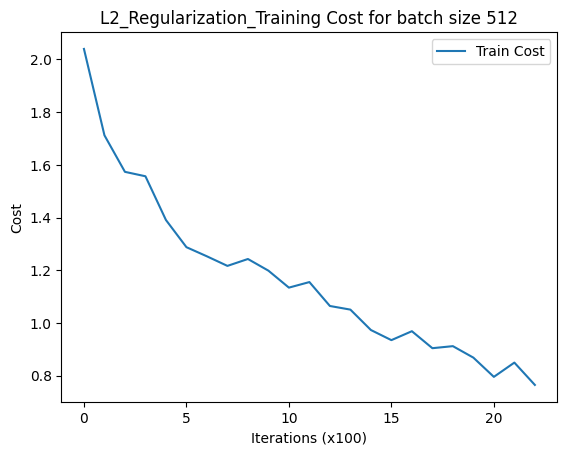

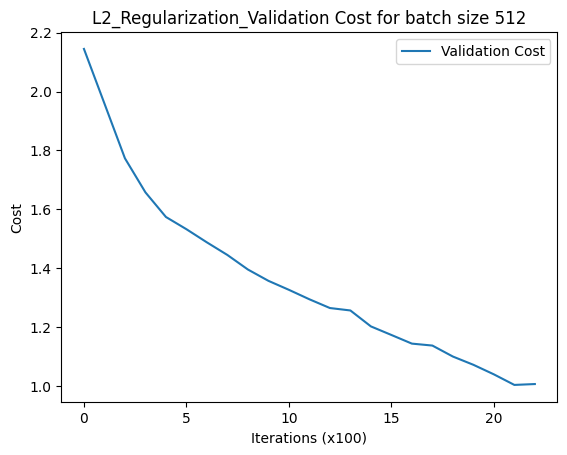

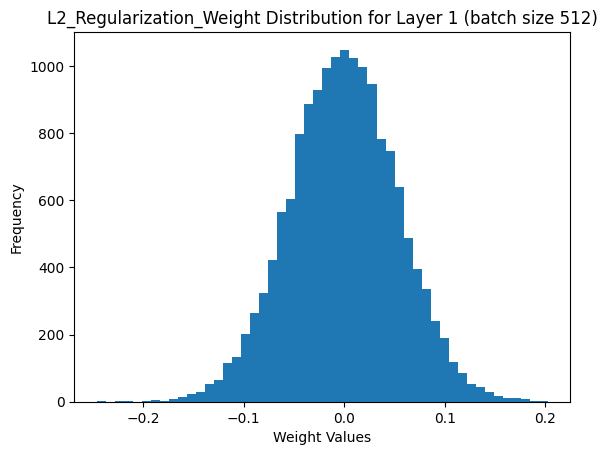

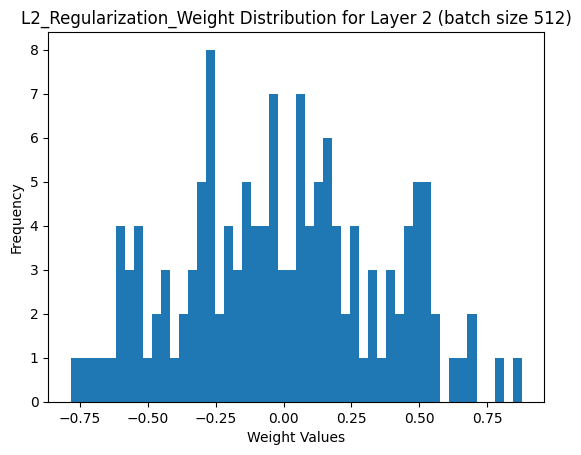

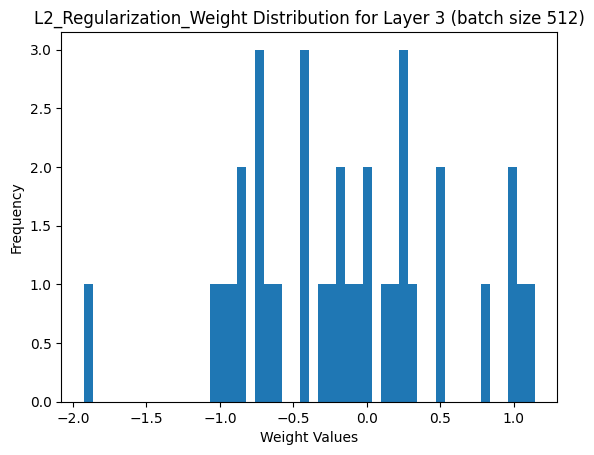

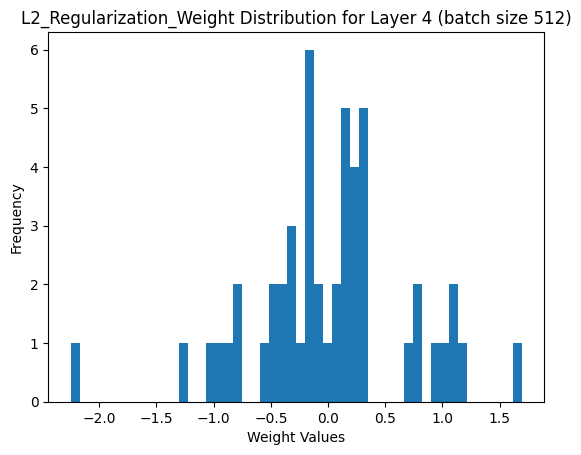

Batch size: 512
Train Accuracy: 0.6889791666666667
Validation Accuracy: 0.6901666666666667
Test Accuracy: 0.6883
Final Train Cost: 0.7652852503028847
Final Validation Cost: 1.0064445467748206
------------------------------------------------------------



In [ ]:
def run_experiments():
  batch_sizes = [512] #[64, 128, 256, 512]
  best_results = {}

  for batch_size in batch_sizes:
    best_cost = float('inf')
    best_parameters = None
    best_train_costs = None
    best_average_epoch_costs = None
    best_val_costs = None
    best_train_accuracy = 0
    best_val_accuracy = 0
    best_test_accuracy = 0
    initial_parameters = None
    num_runs = [1]

    for run in num_runs:
      # Load data
      train_loader, test_loader = load_mnist_data()

      # Convert data to numpy arrays
      X_train, Y_train = convert_to_numpy(train_loader)
      X_test, Y_test = convert_to_numpy(test_loader)

      layers_dims = [784, 20, 7, 5, 10]
      learning_rate = 0.009

      num_iterations = math.ceil(X_train.shape[1] / batch_size) # so that every method call of model is 1 epoch: num_iterations = num_batches

      # Train model
      parameters, train_costs, average_epoch_cost, val_costs, train_accuracy, val_accuracy= L_layer_model_for_plotting(X_train, Y_train, layers_dims, learning_rate, num_iterations, batch_size)

      # Evaluate on train, validation, and test sets
      test_accuracy = Predict(X_test, Y_test, parameters)

      final_train_cost = train_costs[-1]
      final_val_cost = val_costs[-1]

      if final_val_cost < best_cost:
        best_cost = final_val_cost
        best_parameters = parameters
        best_train_costs = train_costs
        best_average_epoch_costs = average_epoch_cost
        best_val_costs = val_costs
        best_train_accuracy = train_accuracy
        best_val_accuracy = val_accuracy
        best_test_accuracy = test_accuracy

    best_results[batch_size] = {
        'parameters': best_parameters,
        'train_costs': best_train_costs,
        'average_epoch_costs': best_average_epoch_costs,
        'val_costs': best_val_costs,
        'train_accuracy': best_train_accuracy,
        'val_accuracy': best_val_accuracy,
        'test_accuracy': best_test_accuracy,
    }

    # Plotting train costs
    plt.figure()
    plt.plot(best_train_costs, label='Train Cost')
    plt.xlabel('Iterations (x100)')
    plt.ylabel('Cost')
    plt.title(f'Training Cost for batch size {batch_size}')
    plt.legend()
    plt.savefig(f'train_costs_batch_size_{batch_size}.png')
    plt.show()

    # Plotting validation costs and average epoch costs
    plt.figure()
    plt.plot(best_val_costs, label='Validation Cost')
    plt.xlabel('Iterations (x100)')
    plt.ylabel('Cost')
    plt.title(f'Validation Cost for batch size {batch_size}')
    plt.legend()
    plt.savefig(f'validation_costs_batch_size_{batch_size}.png')
    plt.show()

    # Plotting weight histograms
    for l in range(1, len(best_parameters) + 1):
      W, b = best_parameters[l]
      plt.figure()
      plt.hist(W.flatten(), bins=50)
      plt.xlabel('Weight Values')
      plt.ylabel('Frequency')
      plt.title(f'Weight Distribution for Layer {l} (batch size {batch_size})')
      plt.savefig(f'weights_histogram_layer_{l}_batch_size_{batch_size}.png')
      plt.show()

# Print best results for each batch size
    for batch_size, result in best_results.items():
      result_log = (
          f'Batch size: {batch_size}\n'
          f'Train Accuracy: {result["train_accuracy"]}\n'
          f'Validation Accuracy: {result["val_accuracy"]}\n'
          f'Test Accuracy: {result["test_accuracy"]}\n'
          f'Final Train Cost: {result["train_costs"][-1]}\n'
          f'Final Validation Cost: {result["val_costs"][-1]}\n'
          '------------------------------------------------------------\n'
      )

    print(result_log)

    append_to_log_file(f'results_{batch_size}.txt', result_log)

run_experiments()